In [1]:
import config as c
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys

# Descriptive Analysis
- demographic data
- fitts' law
    - effective id
    - task completion time (overall & per id)
    - error rate (overall & per id)
    - throughput (overall & per id)
    - regression of error rate
    - regression of task completion time
- nasa-tlx

## Analysis of Demographic Data

In [2]:
demographic_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    demographic_raw = pd.read_csv(
        c.FOLDER_PATH
        + str(id + 1)
        + f"/demographic_participant_{id + 1}.csv"
    )
    demographic_df = pd.concat([demographic_df, demographic_raw])

demographic_df.head()

,participant_id,agreed,age,gender,hand,input_device,mouse,constraints
0,1,True,23,male,right,Mouse,often,NaN
0,2,True,26,female,right,Touchpad,never,NaN
0,3,True,25,male,right,Mouse,often,NaN
0,4,True,24,male,right,Mouse,often,NaN
0,5,True,24,female,right,Touchpad,never,NaN


In [3]:
mean_age = np.mean(demographic_df["age"])
std_age = np.std(demographic_df["age"])
print("Average age: ", mean_age, " (Std: ", std_age, ")")
print(
    "Gender: \n",
    demographic_df["gender"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Handedness: \n",
    demographic_df["hand"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Most used input device: \n",
    demographic_df["input_device"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)
print(
    "Frequency of mouse input: \n",
    demographic_df["mouse"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "value", 0: "count"}),
)

Average age:  26.5  (Std:  3.6674241641784495 )
Gender: 
    gender  count
0    male      7
1  female      3
Handedness: 
     hand  count
0  right     10
Most used input device: 
   input_device  count
0        Mouse      4
1        often      3
2     Touchpad      2
3        never      1
Frequency of mouse input: 
    mouse  count
0  often      4
1  never      2


## Analyis of Fitts' Law 

In [4]:
latency_conditions = [-40, -20, 0, 20, 40]
balanced_latin_square = [[0,1,4,3,2],
                        [4,2,0,3,1],
                        [3,2,1,4,0],
                        [1,0,3,4,2],
                        [4,0,2,1,3],
                        [2,3,4,1,0],
                        [1,3,0,2,4],
                        [0,4,1,2,3],
                        [2,4,3,0,1],
                        [3,1,2,0,4]]

clicks_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    for trial in range(c.NUM_TRIALS):
        clicks_raw = pd.read_csv(
            c.FOLDER_PATH
            + str(id + 1)
            + f"/clicks_participant_{id + 1}_trial_{trial}.csv"
        )
        clicks_raw["level_of_latency"] = latency_conditions[balanced_latin_square[id][trial]]
        clicks_df = pd.concat([clicks_df, clicks_raw])
    
clicks_df.head()

,id,timestamp_ms,participant_id,trial,level_of_latency,target_number,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,0,1710166191603,1,0,-40,0,30,450,959,103,957,107,1,1.787344
1,1,1710166193111,1,0,-40,1,30,450,1113,975,1117,968,1,1.508388
2,2,1710166194311,1,0,-40,2,30,450,670,208,672,211,1,1.199971
3,3,1710166196228,1,0,-40,3,30,450,1349,778,1353,787,1,1.916836
4,4,1710166197495,1,0,-40,4,30,450,516,474,519,467,1,1.267135


In [5]:
# drop irrelevant columns
clicks_df = clicks_df.drop(
    ["timestamp_ms", "target_number"], axis=1
)
# drop rows of first click in round (no fitts law task)
clicks_df = clicks_df.drop(clicks_df.loc[clicks_df["id"] % 9 == 0].index, axis=0)
clicks_df.reset_index(inplace=True, drop=True)
clicks_df

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496
...,...,...,...,...,...,...,...,...,...,...,...,...
14395,319,10,4,40,200,200,763,518,733,513,1,0.400253
14396,320,10,4,40,200,200,1156,518,1150,500,1,0.387485
14397,321,10,4,40,200,200,786,652,775,637,1,0.408640
14398,322,10,4,40,200,200,1088,399,1106,392,1,0.353753


In [6]:
# drop rows with unsuccessful fitts law tasks
error_indices = clicks_df.loc[clicks_df["success"]==0].index
task_after_error_indices = clicks_df.loc[clicks_df["success"]==0].index + 1
clicks_error_df = clicks_df.drop(error_indices, axis=0)
clicks_error_df = clicks_df.drop(task_after_error_indices, axis=0)

clicks_error_df.reset_index(inplace=True, drop=True)
clicks_error_df

,id,participant_id,trial,level_of_latency,target_width,target_amplitude,target_x,target_y,cursor_x,cursor_y,success,completion_time
0,1,1,0,-40,30,450,1113,975,1117,968,1,1.508388
1,2,1,0,-40,30,450,670,208,672,211,1,1.199971
2,3,1,0,-40,30,450,1349,778,1353,787,1,1.916836
3,4,1,0,-40,30,450,516,474,519,467,1,1.267135
4,5,1,0,-40,30,450,1403,474,1409,482,1,1.045496
...,...,...,...,...,...,...,...,...,...,...,...,...
13687,319,10,4,40,200,200,763,518,733,513,1,0.400253
13688,320,10,4,40,200,200,1156,518,1150,500,1,0.387485
13689,321,10,4,40,200,200,786,652,775,637,1,0.408640
13690,322,10,4,40,200,200,1088,399,1106,392,1,0.353753


### Overall Fitts' Law Analysis
- Calculation of id
- Calculation of effective id
- Mean error rate
- Mean completion time
- Mean throughput

In [7]:
# calculation of id
clicks_df["ID"] = np.log2(clicks_df["target_amplitude"] / clicks_df["target_width"] + 1)
clicks_error_df["ID"] = np.log2(clicks_error_df["target_amplitude"] / clicks_error_df["target_width"] + 1)

In [8]:
# calculation of effective id
num_ids = len(clicks_df["ID"].unique())

clicks_df["distance_from_target"] = np.sqrt(
    (clicks_df["target_x"] - clicks_df["cursor_x"])**2 +
    (clicks_df["target_y"] - clicks_df["cursor_y"])**2
)

effective_id_df = pd.DataFrame({"ID": clicks_df["ID"].unique(), 
                                "sigma": np.zeros(num_ids),
                                "amplitude": np.zeros(num_ids),
                                "width": np.zeros(num_ids)})
for _, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            row["amplitude"] = entry["target_amplitude"]
            row["width"] = entry["target_width"]
            row["sigma"] += entry["distance_from_target"]

effective_id_df["sigma"] /= len(clicks_df)/9
effective_id_df["We"] = 4.133 * effective_id_df["sigma"]
effective_id_df["IDe"] = np.log2(
    effective_id_df["amplitude"] / effective_id_df["We"] + 1
)
effective_id_df.sort_values(by=["ID"])

,ID,sigma,amplitude,width,We,IDe
5,1.000000,31.052660,200.0,200.0,128.340645,1.355215
3,1.392317,43.412532,325.0,200.0,179.423994,1.491264
8,1.415037,25.310623,200.0,120.0,104.608803,1.541953
6,1.700440,45.337543,450.0,200.0,187.380066,1.766186
2,1.890771,28.969335,325.0,120.0,119.730262,1.893143
7,2.247928,27.515706,450.0,120.0,113.722411,2.309468
4,2.938599,8.739127,200.0,30.0,36.118814,2.708691
1,3.564785,8.955104,325.0,30.0,37.011443,3.289992
0,4.000000,9.303153,450.0,30.0,38.449931,3.667158


In [9]:
def calculate_mean_std(arr):
    return round(np.mean(arr), 2), round(np.std(arr), 2)

In [10]:
# calculation of mean and standard deviation of error rate and completion time
print("Mean error rate: ",  calculate_mean_std(1 - clicks_df["success"]))
print("Mean completion time: ",  calculate_mean_std(clicks_df["completion_time"]))

Mean error rate:  (0.05, 0.22)
Mean completion time:  (0.65, 0.25)


In [11]:
# calculation of throughput
throughput_df = pd.DataFrame({"IDe": np.zeros(clicks_error_df.shape[0]),
                              "completion_time": clicks_error_df["completion_time"],
                              "level_of_latency": clicks_error_df["level_of_latency"],
                              "participant_id": clicks_error_df["participant_id"]})

for index, entry in clicks_error_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            throughput_df.loc[index,"IDe"] = row["IDe"]

throughput_df["throughput"] = throughput_df["IDe"] / throughput_df["completion_time"]
print("Mean throughput: ",  calculate_mean_std(throughput_df["throughput"]))

Mean throughput:  (3.6, 0.93)


In [12]:
error_df = pd.DataFrame({"IDe": np.zeros(clicks_df.shape[0]),
                        "error_rate": 1 - clicks_df["success"],
                        "level_of_latency": clicks_df["level_of_latency"],
                        "participant_id": clicks_df["participant_id"]})

for index, entry in clicks_df.iterrows():
    for _, row in effective_id_df.iterrows():
        if entry["ID"] == row["ID"]:
            error_df.loc[index,"IDe"] = row["IDe"]
error_df.head()

,IDe,error_rate,level_of_latency,participant_id
0,3.667158,0,-40,1
1,3.667158,0,-40,1
2,3.667158,0,-40,1
3,3.667158,0,-40,1
4,3.667158,0,-40,1


In [13]:
# calculation of throughput, error rate, completion time per id
ides = throughput_df["IDe"].unique()
throughput_df_per_id = pd.DataFrame({"IDe": ides,
                                     "mean_throughput": np.zeros(len(ides)),
                                     "std_throughput": np.zeros(len(ides)),
                                     "mean_completion_time": np.zeros(len(ides)),
                                     "std_completion_time": np.zeros(len(ides))})
error_df_per_id = pd.DataFrame({"IDe": ides,
                                "mean_error_rate": np.zeros(len(ides)),
                                "std_error_rate": np.zeros(len(ides))})

for _, entry in throughput_df_per_id.iterrows():
    id = entry["IDe"]
    queried_df = throughput_df.query(f"IDe=={id}")
    throughput = queried_df["throughput"]
    completion_time = queried_df["completion_time"]
    entry["mean_throughput"], entry["std_throughput"] = calculate_mean_std(throughput)
    entry["mean_completion_time"], entry["std_completion_time"] = calculate_mean_std(completion_time)

for _, entry in error_df_per_id.iterrows():
    id = entry["IDe"]
    queried_df = error_df.query(f"IDe=={id}")
    error_rate = queried_df["error_rate"]
    entry["mean_error_rate"], entry["std_error_rate"] = calculate_mean_std(error_rate * 100)

throughput_df_per_id["IDe"] = round(throughput_df_per_id["IDe"], 2)
error_df_per_id["IDe"] = round(error_df_per_id["IDe"], 2)
throughput_df_per_id = throughput_df_per_id.sort_values(by=["IDe"])
throughput_df_per_id

,IDe,mean_throughput,std_throughput,mean_completion_time,std_completion_time
5,1.36,3.32,1.02,0.45,0.14
3,1.49,3.42,0.93,0.47,0.13
8,1.54,3.55,1.03,0.47,0.13
6,1.77,3.35,0.83,0.56,0.15
2,1.89,3.53,0.87,0.57,0.14
7,2.31,3.73,0.80,0.65,0.14
4,2.71,3.69,0.88,0.78,0.21
1,3.29,3.91,0.88,0.89,0.22
0,3.67,3.92,0.84,0.98,0.23


In [14]:
error_df_per_id.sort_values(by=["IDe"])

,IDe,mean_error_rate,std_error_rate
5,1.36,0.50,7.05
3,1.49,2.44,15.42
8,1.54,2.19,14.63
6,1.77,3.81,19.15
2,1.89,3.56,18.54
7,2.31,3.81,19.15
4,2.71,8.00,27.13
1,3.29,8.50,27.89
0,3.67,11.44,31.83


In [15]:
throughput_df.groupby(["level_of_latency"]).mean()

,IDe,completion_time,participant_id,throughput
level_of_latency,,,,
-40,2.202114,0.689530,5.540620,3.348057
-20,2.198018,0.635215,5.500363,3.594074
0,2.201291,0.622889,5.500548,3.723101
20,2.206485,0.609482,5.503448,3.727327
40,2.197825,0.643196,5.521183,3.580906


In [16]:
throughput_df.groupby(["level_of_latency"]).std()

,IDe,completion_time,participant_id,throughput
level_of_latency,,,,
-40,0.777460,0.280005,2.881897,0.817221
-20,0.774346,0.248964,2.870526,0.799623
0,0.776096,0.243992,2.882966,1.061019
20,0.778498,0.221604,2.881509,0.885566
40,0.776476,0.248024,2.870565,0.990659


In [17]:
error_mean_df = error_df.groupby(["level_of_latency"], as_index=False).mean()
error_mean_df

,level_of_latency,IDe,error_rate,participant_id
0,-40,2.224786,0.059375,5.5
1,-20,2.224786,0.044097,5.5
2,0,2.224786,0.049653,5.5
3,20,2.224786,0.043056,5.5
4,40,2.224786,0.049653,5.5


In [18]:
error_std_df = error_df.groupby(["level_of_latency"], as_index=False).std()
error_std_df

,level_of_latency,IDe,error_rate,participant_id
0,-40,0.784512,0.236366,2.87278
1,-20,0.784512,0.205347,2.87278
2,0,0.784512,0.217264,2.87278
3,20,0.784512,0.203017,2.87278
4,40,0.784512,0.217264,2.87278


In [19]:
error_df.groupby(
        ["level_of_latency", "IDe"], as_index=False
    ).mean()


,level_of_latency,IDe,error_rate,participant_id
0,-40,1.355215,0.003125,5.5
1,-40,1.491264,0.034375,5.5
2,-40,1.541953,0.025000,5.5
3,-40,1.766186,0.059375,5.5
4,-40,1.893143,0.068750,5.5
5,-40,2.309468,0.043750,5.5
6,-40,2.708691,0.084375,5.5
7,-40,3.289992,0.087500,5.5
8,-40,3.667158,0.128125,5.5
9,-20,1.355215,0.000000,5.5


C:\Users\sinas\AppData\Local\Temp\ipykernel_34776\1812415375.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["-40", "-20", "0", "20", "40"])


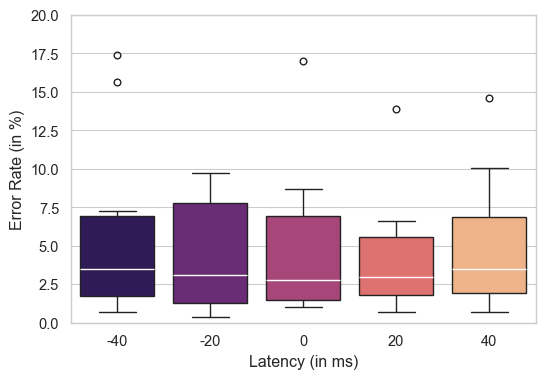

In [20]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()

p = sns.boxplot(
    data=error_df.groupby(
        ["participant_id", "level_of_latency"], as_index=False
    ).mean()*100,
    x="level_of_latency",
    y="error_rate",
    hue="level_of_latency",
    palette=palette,
    showfliers=True,
    medianprops={"color": "white", "label": "_median_"},
)
# sns.swarmplot(
#     data=error_df.groupby(
#         ["participant_id", "level_of_latency"], as_index=False
#     ).mean()*100,
#     x="level_of_latency",
#     y="error_rate",
#     palette=palette,
#     edgecolor="black",
#     linewidth=0.5,
#     alpha=0.5,
#     dodge=True,
#     legend=False,
# )


ax.set_xlabel("Latency (in ms)")
ax.set_ylabel("Error Rate (in %)")
ax.set_xticklabels(["-40", "-20", "0", "20", "40"])

ax.get_legend().set_visible(False)
ax.set_ylim(0, 20)
plt.savefig('figures/boxplot_error_rate.pdf', bbox_inches='tight')
plt.savefig('figures/boxplot_error_rate.png', bbox_inches='tight')

C:\Users\sinas\AppData\Local\Temp\ipykernel_34776\1703831906.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["-40", "-20", "0", "20", "40"])


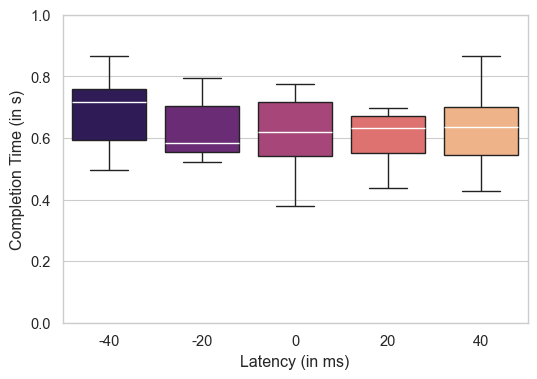

In [21]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()

p = sns.boxplot(
    data=throughput_df.groupby(
        ["participant_id", "level_of_latency"], as_index=False
    ).mean(),
    x="level_of_latency",
    y="completion_time",
    hue="level_of_latency",
    palette=palette,
    showfliers=True,
    medianprops={"color": "white", "label": "_median_"},
)
# sns.swarmplot(
#     data=error_df.groupby(
#         ["participant_id", "level_of_latency"], as_index=False
#     ).mean()*100,
#     x="level_of_latency",
#     y="error_rate",
#     palette=palette,
#     edgecolor="black",
#     linewidth=0.5,
#     alpha=0.5,
#     dodge=True,
#     legend=False,
# )


ax.set_xlabel("Latency (in ms)")
ax.set_ylabel("Completion Time (in s)")
ax.set_xticklabels(["-40", "-20", "0", "20", "40"])

ax.get_legend().set_visible(False)
ax.set_ylim(0, 1)
plt.savefig('figures/boxplot_completion_time.pdf', bbox_inches='tight')
plt.savefig('figures/boxplot_completion_time.png', bbox_inches='tight')

C:\Users\sinas\AppData\Local\Temp\ipykernel_34776\3809825889.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["-40", "-20", "0", "20", "40"])


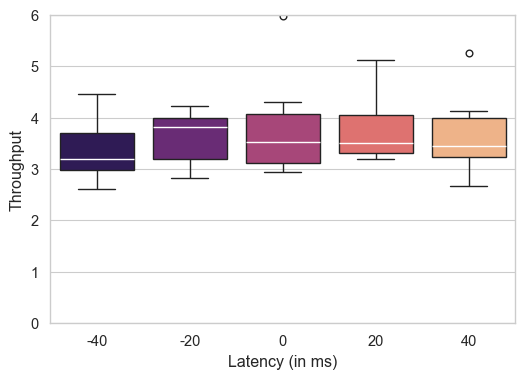

In [22]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()

p = sns.boxplot(
    data=throughput_df.groupby(
        ["participant_id", "level_of_latency"], as_index=False
    ).mean(),
    x="level_of_latency",
    y="throughput",
    hue="level_of_latency",
    palette=palette,
    showfliers=True,
    medianprops={"color": "white", "label": "_median_"},
)
# sns.swarmplot(
#     data=error_df.groupby(
#         ["participant_id", "level_of_latency"], as_index=False
#     ).mean()*100,
#     x="level_of_latency",
#     y="error_rate",
#     palette=palette,
#     edgecolor="black",
#     linewidth=0.5,
#     alpha=0.5,
#     dodge=True,
#     legend=False,
# )


ax.set_xlabel("Latency (in ms)")
ax.set_ylabel("Throughput")
ax.set_xticklabels(["-40", "-20", "0", "20", "40"])

ax.get_legend().set_visible(False)
ax.set_ylim(0, 6)
plt.savefig('figures/boxplot_throughput.pdf', bbox_inches='tight')
plt.savefig('figures/boxplot_throughput.png', bbox_inches='tight')

(0.0, 0.2)

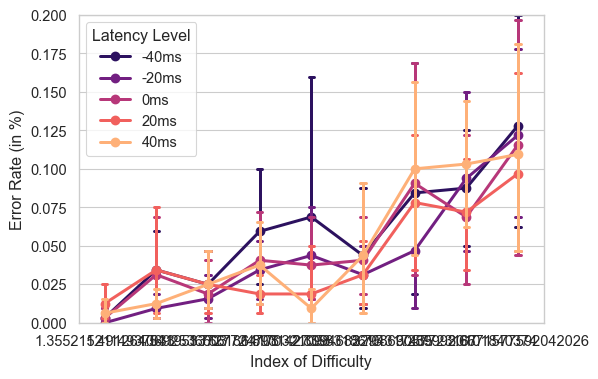

In [23]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()


sns.pointplot(
    data=error_df.groupby(
        ["participant_id", "level_of_latency", "IDe"], as_index=False
    ).mean(),
    x="IDe",
    y="error_rate",
    hue="level_of_latency",
    palette=palette,
    capsize=.1
)

ax.set_xlabel("Index of Difficulty")
ax.set_ylabel("Error Rate (in %)")

handles, labels = ax.get_legend_handles_labels()
labels = ["-40ms", "-20ms", "0ms", "20ms", "40ms"]
ax.legend(title="Latency Level", handles=handles, labels=labels)


ax.set_ylim(0, 0.20)
# plt.savefig('figures/boxplot_error_rate.pdf', bbox_inches='tight')

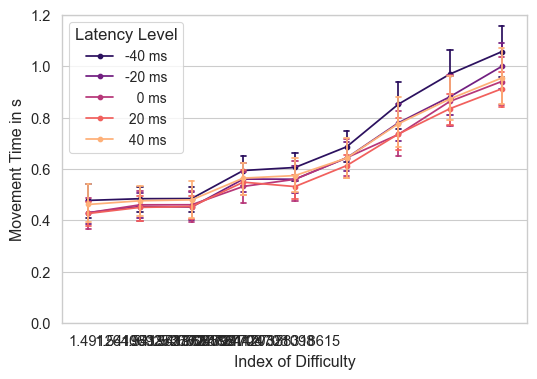

In [24]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper", rc={"lines.linewidth": 0.7})
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()

sns.pointplot(
    data=throughput_df.groupby(
        ["participant_id", "level_of_latency", "IDe"], as_index=False
    ).mean(),
    x="IDe",
    y="completion_time",
    hue="level_of_latency",
    palette=palette,
    capsize=.1
)

ax.set_xlabel("Index of Difficulty")
ax.set_ylabel("Movement Time in s")

handles, labels = ax.get_legend_handles_labels()
labels = ["-40 ms", "-20 ms", "   0 ms", " 20 ms", " 40 ms"]
ax.legend(title="Latency Level", handles=handles, labels=labels, fontsize=10, title_fontsize= 12)

ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 4, 0.5))
# plt.savefig('figures/boxplot_error_rate.pdf', bbox_inches='tight')

In [25]:
throughput_df.groupby(
        ["participant_id", "level_of_latency", "IDe"], as_index=False
    ).mean()

,participant_id,level_of_latency,IDe,completion_time,throughput
0,1,-40,1.355215,0.517865,2.742676
1,1,-40,1.491264,0.475561,3.186644
2,1,-40,1.541953,0.473786,3.301491
3,1,-40,1.766186,0.636903,2.896256
4,1,-40,1.893143,0.562807,3.462606
...,...,...,...,...,...
445,10,40,1.893143,0.548467,3.496806
446,10,40,2.309468,0.520840,4.482338
447,10,40,2.708691,0.611663,4.544814
448,10,40,3.289992,0.773980,4.307370


In [26]:
throughput_df

,IDe,completion_time,level_of_latency,participant_id,throughput
0,3.667158,1.508388,-40,1,2.431177
1,3.667158,1.199971,-40,1,3.056039
2,3.667158,1.916836,-40,1,1.913131
3,3.667158,1.267135,-40,1,2.894055
4,3.667158,1.045496,-40,1,3.507577
...,...,...,...,...,...
13687,1.355215,0.400253,40,10,3.385896
13688,1.355215,0.387485,40,10,3.497465
13689,1.355215,0.408640,40,10,3.316404
13690,1.355215,0.353753,40,10,3.830965


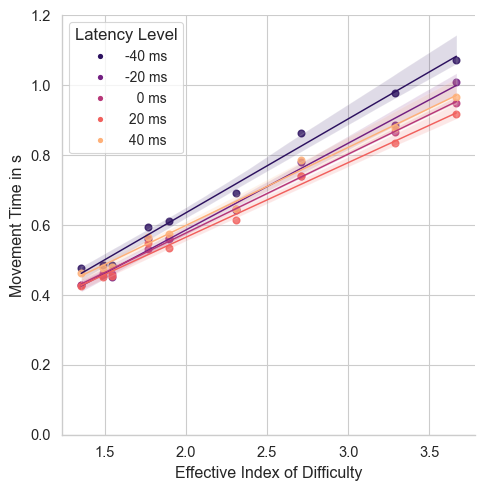

In [27]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper", rc={"lines.linewidth": 0.7})
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)

ax = sns.lmplot(
    data=throughput_df.groupby(
        ["level_of_latency", "IDe"], as_index=False
    ).mean(),
    x="IDe",
    y="completion_time",
    hue="level_of_latency",
    palette=palette,
    legend=False
)

ax.set(xlabel="Effective Index of Difficulty", ylabel="Movement Time in s", ylim=[0, 1.2])
labels = ["-40 ms", "-20 ms", "   0 ms", " 20 ms", " 40 ms"]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[labels.index(label)], label=label) for label in labels]
plt.legend(title="Latency Level", labels=labels, handles=handles, fontsize=10, title_fontsize= 12)
plt.savefig('figures/regression_id_mt.png', bbox_inches='tight')

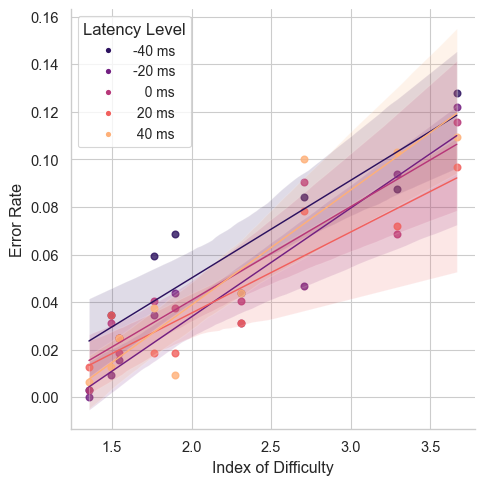

In [28]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper", rc={"lines.linewidth": 0.7})
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)

ax = sns.lmplot(
    data=error_df.groupby(
        ["level_of_latency", "IDe"], as_index=False
    ).mean(),
    x="IDe",
    y="error_rate",
    hue="level_of_latency",
    palette=palette,
    legend=False
)

ax.set(xlabel="Index of Difficulty", ylabel="Error Rate")
labels = ["-40 ms", "-20 ms", "   0 ms", " 20 ms", " 40 ms"]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[labels.index(label)], label=label) for label in labels]
plt.legend(title="Latency Level", labels=labels, handles=handles, fontsize=10, title_fontsize= 12)
# plt.savefig('figures/regression_id_mt.pdf', bbox_inches='tight')

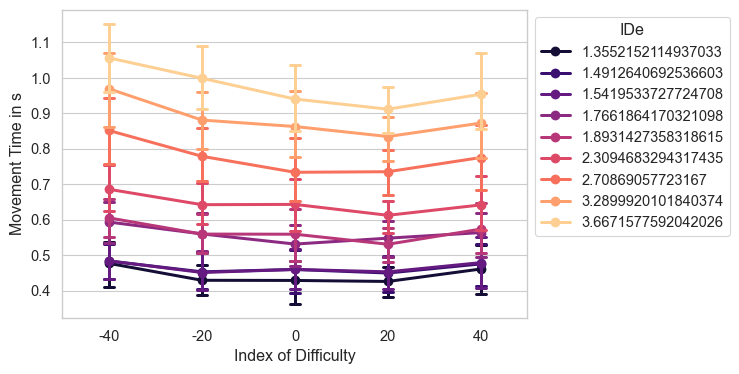

In [29]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")
palette = sns.color_palette("magma", 9)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()

sns.pointplot(
    data=throughput_df.groupby(
        ["participant_id", "level_of_latency", "IDe"], as_index=False
    ).mean(),
    x="level_of_latency",
    y="completion_time",
    hue="IDe",
    palette=palette,
    capsize=.1
)

ax.set_xlabel("Index of Difficulty")
ax.set_ylabel("Movement Time in s")

# 
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# ax.set_y(0, 0.20)
# plt.savefig('figures/boxplot_error_rate.pdf', bbox_inches='tight')

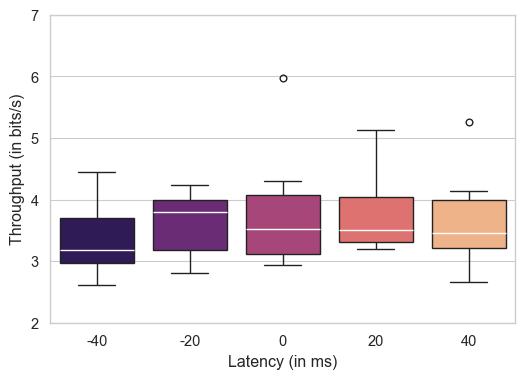

In [30]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)
fig2 = plt.figure(figsize=(6, 4))
ax = plt.gca()

p = sns.boxplot(
    data=throughput_df.groupby(
        ["participant_id", "level_of_latency"], as_index=False
    ).mean(),
    x="level_of_latency",
    y="throughput",
    hue="level_of_latency",
    palette=palette,
    showfliers=True,
    medianprops={"color": "white", "label": "_median_"},
)


ax.set_xlabel("Latency (in ms)")
ax.set_ylabel("Throughput (in bits/s)")

ax.get_legend().set_visible(False)
ax.set_ylim(2, 7)
plt.savefig('figures/boxplot_throughput.pdf', bbox_inches='tight')

## Fitts' Law Regression
- Regression model for error rate
- Regression model for completion time

In [31]:
def model_error_rate(x):
    slope_error_rate, intercept_error_rate, r_error_rate, p, std_err = stats.linregress(
        error_df_per_id["IDe"], error_df_per_id["mean_error_rate"]
    )
    return slope_error_rate * x + intercept_error_rate
slope_error_rate, intercept_error_rate, r_error_rate, p_error, std_err = stats.linregress(
        error_df_per_id["IDe"], error_df_per_id["mean_error_rate"]
    )
p_error

1.3643956888653996e-05

In [32]:
def model_completion_time(x):
  slope_completion_time, intercept_completion_time, r_completion_time, p, std_err = stats.linregress(
    throughput_df_per_id["IDe"], throughput_df_per_id["mean_completion_time"]
    )
  return slope_completion_time * x + intercept_completion_time
slope_completion_time, intercept_completion_time, r_completion_time, p_time, std_err = stats.linregress(
    throughput_df_per_id["IDe"], throughput_df_per_id["mean_completion_time"]
    )
p_error

1.3643956888653996e-05

In [33]:
ide = effective_id_df["IDe"]
completion_time = throughput_df_per_id["mean_completion_time"]
e_completion_time = throughput_df_per_id["std_completion_time"] * 1.96 / np.sqrt(throughput_df_per_id.shape[1])
error_rate = error_df_per_id["mean_error_rate"]
e_error_rate = error_df_per_id["std_error_rate"] * 1.96 / np.sqrt(error_df_per_id.shape[1])

regr_completion_time = list(map(model_completion_time, ide))
regr_error_rate = list(map(model_error_rate, ide))

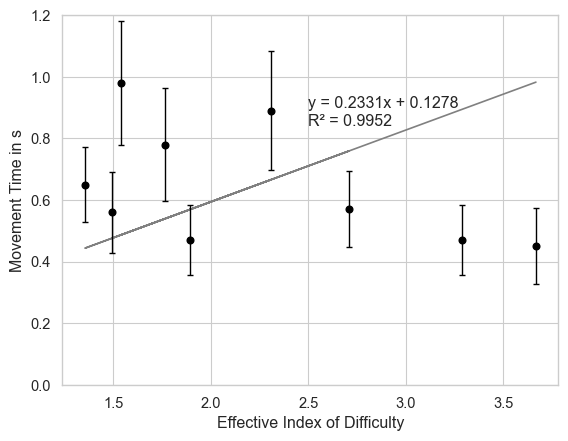

In [34]:
# regression plot for completion time
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')

plt.plot(ide, regr_completion_time, color="grey")
plt.errorbar(ide, completion_time, e_completion_time, linestyle='None', capsize=2, fmt="o", color="black", elinewidth=1)
plt.xlabel("Effective Index of Difficulty")
plt.ylabel("Movement Time in s")

plt.ylim(0, 1.2)
plt.text(2.5, 0.84, 'R² = '+ str(round(r_completion_time**2, 4)))
plt.text(2.5, 0.9, 'y = '+ str(round(slope_completion_time, 4)) + "x + " + str(round(intercept_completion_time, 4)))
plt.savefig('figures/regression_completion_time.pdf', bbox_inches='tight')
plt.show()

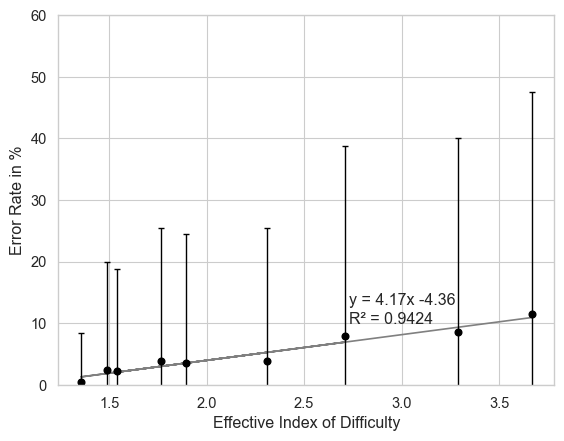

In [35]:
# regression plot for error rate
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')

plt.plot(ide, regr_error_rate, color="grey")
plt.errorbar(ide, error_rate, e_error_rate, linestyle='None', capsize=2, fmt="o", color="black", elinewidth=1)
plt.xlabel("Effective Index of Difficulty")
plt.ylabel("Error Rate in %")

plt.ylim(0, 60)
plt.text(2.73, 10, 'R² = '+ str(round(r_error_rate**2, 4)))
plt.text(2.73, 13, 'y = '+ str(round(slope_error_rate, 3)) + "x " + str(round(intercept_error_rate, 2)))
plt.savefig('figures/regression_error_rate.pdf', bbox_inches='tight')
plt.show()

## NASA-TLX

In [36]:
tlx_df = pd.DataFrame()
for id in range(c.NUM_PARTICIPANTS):
    tlx_raw = pd.read_csv(
        c.FOLDER_PATH
        + str(id + 1)
        + f"/tlx_participant_{id + 1}.csv"
    )
    tlx_raw["level_of_latency"] = balanced_latin_square[id]
    tlx_df = pd.concat([tlx_df, tlx_raw])

tlx_df.head()

,participant_id,trial,latency,mental_demand,physical_demand,temporal_demand,performance,effort,frustration,level_of_latency
0,1,0,0,8.0,10.0,16.2,2.0,13.0,4.8,0
1,1,1,0,14.0,10.8,14.2,8.4,12.2,11.2,1
2,1,2,0,16.4,15.8,8.6,12.2,14.0,8.6,4
3,1,3,0,10.8,13.0,4.6,6.6,11.0,4.0,3
4,1,4,0,8.2,8.2,12.2,6.2,7.0,4.4,2


In [37]:
tlx_df.drop(["participant_id", "latency"], axis=1, inplace=True)

In [38]:
# calculate overall scores
overall_tlx_df = tlx_df.drop(["trial"], axis=1)
for score in overall_tlx_df.columns:
    mean, std = calculate_mean_std(overall_tlx_df[score]*5)
    print(score + ": " + str(mean) + " (" + str(std) + ")")

mean, std = calculate_mean_std(overall_tlx_df.drop(["level_of_latency"], axis=1).to_numpy()*5)
print("overall score: "+ str(mean) + " (" + str(std) + ")")

mental_demand: 38.3 (25.89)
physical_demand: 28.72 (22.99)
temporal_demand: 33.02 (29.43)
performance: 33.18 (19.45)
effort: 38.48 (20.85)
frustration: 35.14 (21.32)
level_of_latency: 10.0 (7.07)
overall score: 34.47 (23.81)


In [39]:
# calculate scores per trial
trial = 0
trials = tlx_df["level_of_latency"].unique()
print(trials)
tlx_trial_df = pd.DataFrame(
    {
        "trial": trials,
        "mean_score": np.zeros(len(trials)),
        "mean_mental_demand": np.zeros(len(trials)),
        "mean_physical_demand": np.zeros(len(trials)),
        "mean_temporal_demand": np.zeros(len(trials)),
        "mean_performance": np.zeros(len(trials)),
        "mean_effort": np.zeros(len(trials)),
        "mean_frustration": np.zeros(len(trials)),
    }
)

tlx_std_trial_df = pd.DataFrame(
    {
        "trials": trials,
        "std_score": np.zeros(len(trials)),
        "std_mental_demand": np.zeros(len(trials)),
        "std_physical_demand": np.zeros(len(trials)),
        "std_temporal_demand": np.zeros(len(trials)),
        "std_performance": np.zeros(len(trials)),
        "std_effort": np.zeros(len(trials)),
        "std_frustration": np.zeros(len(trials)),
    }
)

for level_of_latency in tlx_df["level_of_latency"].unique():
    trial_df = tlx_df.query(f"level_of_latency=={level_of_latency}").drop(["level_of_latency"], axis=1)

    (
        tlx_trial_df.loc[trial, "mean_score"],
        tlx_std_trial_df.loc[trial, "std_score"],
    ) = calculate_mean_std(trial_df.to_numpy()*5)


    (
        tlx_trial_df.loc[trial, "mean_mental_demand"],
        tlx_std_trial_df.loc[trial, "std_mental_demand"],
    ) = calculate_mean_std(trial_df["mental_demand"]*5)

    (
        tlx_trial_df.loc[trial, "mean_physical_demand"],
        tlx_std_trial_df.loc[trial, "std_physical_demand"],
    ) = calculate_mean_std(trial_df["physical_demand"]*5)

    (
        tlx_trial_df.loc[trial, "mean_temporal_demand"],
        tlx_std_trial_df.loc[trial, "std_temporal_demand"],
    ) = calculate_mean_std(trial_df["temporal_demand"]*5)

    (
        tlx_trial_df.loc[trial, "mean_performance"],
        tlx_std_trial_df.loc[trial, "std_performance"],
    ) = calculate_mean_std(trial_df["performance"]*5)

    (
        tlx_trial_df.loc[trial, "mean_effort"],
        tlx_std_trial_df.loc[trial, "std_effort"],
    ) = calculate_mean_std(trial_df["effort"]*5)

    (
        tlx_trial_df.loc[trial, "mean_frustration"],
        tlx_std_trial_df.loc[trial, "std_frustration"],
    ) = calculate_mean_std(trial_df["frustration"]*5)
    trial+=1

[0 1 4 3 2]


In [40]:
tlx_trial_df = tlx_trial_df.sort_values("trial")
tlx_trial_df.reset_index(inplace=True, drop=True)

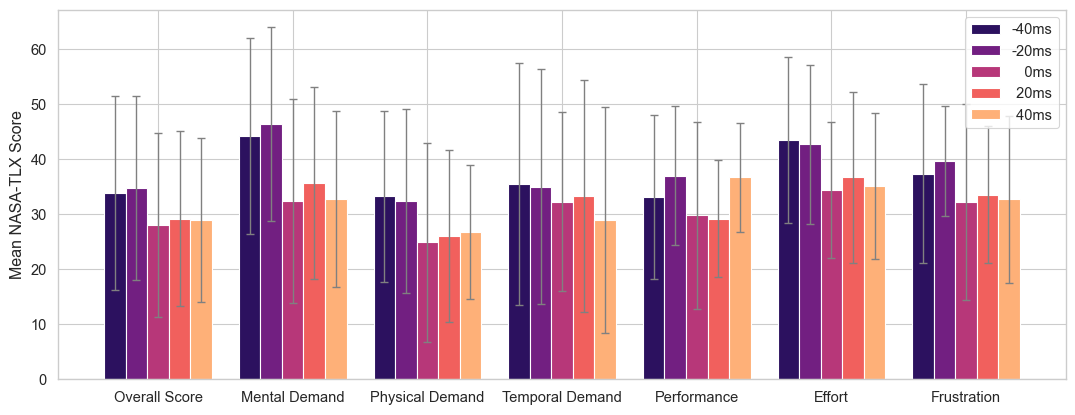

In [41]:
scores = ("Overall Score", "Mental Demand", "Physical Demand", "Temporal Demand", "Performance", "Effort", "Frustration")
x = np.arange(1, len(scores) + 1, 1)
sns.set_theme(style='whitegrid', font_scale=1.2, context='paper')
palette = sns.color_palette("magma", 5)
sns.set_palette(palette)

multiplier = 0
margin = 0.1
width = (1 - 2 * margin)/5
latencies = ["-40ms", "-20ms", "   0ms", " 20ms", " 40ms"]

fig, ax = plt.subplots()

fig.set_figwidth(13)

for trial, entry in tlx_trial_df.drop(["trial"], axis=1).iterrows():
    offset = width * multiplier + margin
    rects = ax.bar(x + offset, entry, width, label=latencies[trial])
    e = tlx_std_trial_df.drop(["trials"], axis=1).loc[trial] * 1.96 / np.sqrt(tlx_std_trial_df.shape[1])
    (_, caps, _) = ax.errorbar(x + offset, entry, e, linestyle='None', capsize=3, fmt="", color="grey", elinewidth=1)
    for cap in caps:
        cap.set_markeredgewidth(1)
    multiplier += 1

plt.ylabel("Mean NASA-TLX Score")

plt.legend(loc='upper right')
ax.set_xticks(x + 2 * width + margin, scores)
plt.savefig('figures/nasa_tlx.pdf', bbox_inches='tight')
plt.savefig('figures/nasa_tlx.png', bbox_inches='tight')
plt.show()